# Uredan

## Setup

In [1]:
!pip install --quiet wikipedia langchain-core langchain-openai langgraph
!pip install --quiet pandas gradio typing IPython tabulate

In [2]:
import pandas as pd
import gradio as gr
from wqapi import WaterQuality
from municipios import provincias, provincias_, municipios

import os, getpass

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

from typing import Annotated
import wikipedia
import time

# Class to access API data
wq = WaterQuality()

# Global variables
county_id, municipality_id = "", ""
point_id, date = "", ""
points, data = pd.DataFrame(), pd.DataFrame()

## LLM

In [12]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [13]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

## Tools

In [14]:
@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
) -> str:
    """Use this to search Wikipedia for factual information."""
    try:
        # Step 1: Search using query
        results = wikipedia.search(query)
        
        if not results:
            return "No results found on Wikipedia."
        
        # Step 2: Retrieve page title
        title = results[0]

        # Step 3: Fetch summary
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\nWikipedia summary: {summary}"
    return result_str

In [15]:
def find_ids(municipio):
    provincia, county_id, municipality_id = "", "", ""
    for province, munis in municipios.items():
        if municipio in munis:
            provincia = province
            break
    if provincia:
        county_id = provincias[provincia]
        municipality_id = municipios[provincia][municipio]
    else:
        municipality_id = "Not found"
    return county_id, municipality_id

@tool
def get_points_tool(
    municipio: Annotated[str, "Name of the municipality."],
) -> str:
    """
    Use this tool to retrieve sample points for a given municipality.
    """
    county_id, municipality_id = find_ids(municipio)
    df =  wq.sampling_points(county_id, municipality_id)
    return f"Sample points retrieval tool for {municipio}:\n\n{df.to_markdown()}"

In [16]:
@tool
def get_data_tool(
    point_id: Annotated[str, "Identifier of the sample point."],
    date: Annotated[str, "Date in which the sample was taken."]
) -> str:
    """
    Use this tool to retrieve analitycal data for a sample point identifier and a date.
    """
    df =  wq.analytical_data(point_id, date)
    return f"Analytical data retrieval tool for point {point_id} in {date}:\n\n{df.to_markdown()}"

In [17]:
tools = [wikipedia_tool, get_points_tool, get_data_tool]

llm_with_tools = llm.bind_tools(tools)

## Graph

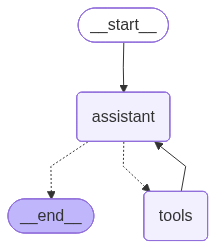

In [18]:
# Assistant
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
graph_builder = StateGraph(MessagesState)

# Define nodes
graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", ToolNode(tools))

# Define edges
graph_builder.add_edge(START, "assistant")
graph_builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "assistant")

# Compile
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))

## UI (Gradio)

In [19]:
config = {"configurable": {"thread_id": "1"}}

def newthread():
    global config
    thread = str(int(config["configurable"]["thread_id"]) + 1)
    config = {"configurable": {"thread_id": thread}}
    
def stream_updates(message, history):
    start_time = time.time()
    response = gr.ChatMessage(
        content="",
        metadata={"title": "_Working..._", "id": 0, "status": "pending"}
    )
    yield response
    
    messages = [HumanMessage(content=message)]
    accumulated_msgs, answer = "", ""
    for event in graph.stream({"messages": messages}, config, stream_mode="updates"):
        for node, msgsdict in event.items():
            for msg in msgsdict["messages"]:
                accumulated_msgs += f"- Node {node}: {msg.__class__.__name__}\n"
                if msg.content:
                    answer = msg.content
                    accumulated_msgs += f"{msg.content}\n\n"
                elif msg.additional_kwargs["tool_calls"]:
                    for tool_call in msg.additional_kwargs["tool_calls"]:
                        accumulated_msgs += f"Tool call: {tool_call['function']['name']}, arguments: {tool_call['function']['arguments']}\n\n"  
                response.content = accumulated_msgs.strip()
                yield response
    
    response.metadata["title"] = "_Finished!_"
    response.metadata["status"] = "done"
    response.metadata["duration"] = time.time() - start_time
    yield response

    response = [
        response,
        gr.ChatMessage(
            content=answer
        )
    ]
    yield response

In [20]:
# Web app with gradio
with gr.Blocks() as demo:

    #### COMPONENTS ####

    # Row 1: Header
    with gr.Row():
    
        # Column 1
        with gr.Column(scale=0):
            gr.Markdown(
                """
                __Aguas de consumo de Euskadi__  
                La API de aguas de consumo permite obtener los datos
                registrados por la [Red de Control y Vigilancia
                de las aguas de consumo de Euskadi](https://www.euskadi.eus/informacion/red-de-control-y-vigilancia-de-las-aguas-de-consumo-de-euskadi/web01-a3aguas/es/).

                API base URI → 'api.euskadi.eus/water-quality'
                """
            )
    
        # Column 2
        with gr.Column(scale=0):
            gr.Image("img/agua.jpg")


    # Tab 1
    with gr.Tab("Manual"):

        # Row 2
        with gr.Row():
        
            # Column
            with gr.Column(scale=0):
                provincia_drp = gr.Dropdown(
                    choices=list(provincias.keys()),
                    value=None, # No value initially
                    label="Selecciona la provincia:",
                    interactive=True)
                
                municipio_drp = gr.Dropdown(
                    choices=[],
                    label="Selecciona el municipio:",
                    interactive=True)
    
        # Row 3
        getpoints_btn = gr.Button("Obtener puntos de muestreo", scale=0)
        
        # Row 4
        points_grdf = gr.Dataframe(type="pandas", wrap=True, interactive=True)
    
        # Row 5
        with gr.Row():
            medicion_drp = gr.Dropdown(
                choices=[],
                label="Selecciona el id:",
                interactive=True)
            
            fecha_drp = gr.Dropdown(
                choices=[],
                label="Selecciona la fecha:",
                interactive=True)
    
        # Row 6
        getdata_btn = gr.Button("Obtener datos analíticos", scale=0)
        
        # Row 7
        data_grdf = gr.Dataframe(type="pandas", wrap=True, interactive=True)


        #### EVENTS ####
        
        # "Provincia" selection, "Municipio" dropdown populate
        def provincia_drp_select(provincia):
            global county_id
            county_id = provincias[provincia]
            return gr.Dropdown(choices=list(municipios[provincia].keys()), value=None)
    
        provincia_drp.select(fn=provincia_drp_select, inputs=provincia_drp, outputs=municipio_drp)
    
        # "Municipio" selection
        def municipio_drp_select(municipio):
            global municipality_id
            municipality_id = municipios[provincias_[int(county_id)]][municipio]
            return None
    
        municipio_drp.select(fn=municipio_drp_select, inputs=municipio_drp, outputs=None)
    
        # Get sample points button
        def getpoints_btn_click():
            global points
            points = wq.sampling_points(county_id, municipality_id)
            return points
        
        getpoints_btn.click(fn=getpoints_btn_click, inputs=None, outputs=points_grdf)
    
        # "Medición id" populate
        def points_grdf_change(df):
            return gr.Dropdown(choices=df.iloc[:, 0].tolist(), value=None)
        
        points_grdf.change(fn=points_grdf_change, inputs=points_grdf, outputs=medicion_drp)
    
        # "Medición id" selection, "fecha" populate
        def medicion_drp_select(medicion_id, df):
            global point_id
            point_id = medicion_id
            return gr.Dropdown(choices=df.loc[df["id"] == medicion_id, "fechas"].tolist()[0])
    
        medicion_drp.select(fn=medicion_drp_select, inputs=[medicion_drp, points_grdf], outputs=fecha_drp)
    
        # "Fecha" selection
        def fecha_drp_select(fecha):
            global date
            date = fecha
            return None
        
        fecha_drp.select(fn=fecha_drp_select, inputs=fecha_drp, outputs=None)
    
        # Get analytical data button
        def getdata_btn_click():
            global data
            data = wq.analytical_data(point_id, date)
            return data
            
        getdata_btn.click(fn=getdata_btn_click, inputs=None, outputs=data_grdf)
    
    # Tab 2
    with gr.Tab("Agente IA"):

        gr.Markdown("## Chatea con el asistente de aguas")
        
        gr.ChatInterface(
            fn=stream_updates, 
            type="messages",
            chatbot= gr.Chatbot(
                label="Agent",
                type="messages",
                avatar_images=(None, "img/robot.svg"),
            ),
        )

        gr.Markdown(
            """
            __Posible secuencia de mensajes de chat dirigidos al agente:__
            1. Obtener puntos de muestreo. Ejemplo:  _Proporciona una lista con los puntos de muestreo disponibles en **Urretxu**_
            2. Obtener datos analíticos. Ejemplo: _Proporciona los datos analíticos para identificador **20032077004** en **2025-03-18**_
            3. Obtener valoración. Ejemplo: _¿La calidad del agua es correcta según los valores de estos parámetros?_
            """
            )

        newthread_btn = gr.Button("+ (nueva conversación)", scale=0)
        newthread_btn.click(fn=newthread)

demo.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
